In [1]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from util.true_gaussian_process import *

from ofm_OT_likelihood import *
from models.fno import FNO

import statsmodels.api as sm
from scipy.stats import binned_statistic
import os

In [2]:

train_samples = 20000

n_x = 32
dims = [n_x, n_x]

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
#spath = Path('../trash/GP')
spath = Path('your_path/GRF_prior_3C')

spath.mkdir(parents=True, exist_ok=True)
saved_model = True # save model

# FNO hyperparameters
modes = 16 # can be applied to 32x32, or 128x128, see the requirement of FNO
width = 128
mlp_width = 128

# GP hyperparameters
#kernel_length=0.1
kernel_length=0.01
kernel_variance=1
nu = 0.5 # default


## Dataset parameters
length_scale_x = 0.4
var_x = 1
nu_x = 1.5

## training parameters
epochs = 500
sigma_min=1e-4
N = 1
batch_size = 256

In [3]:
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

/home/yshi5/miniconda3/envs/torchcfm/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


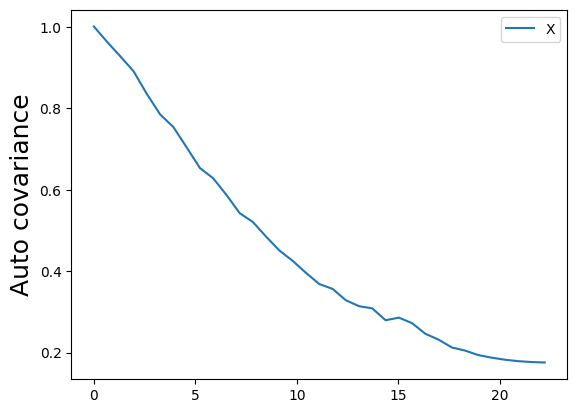

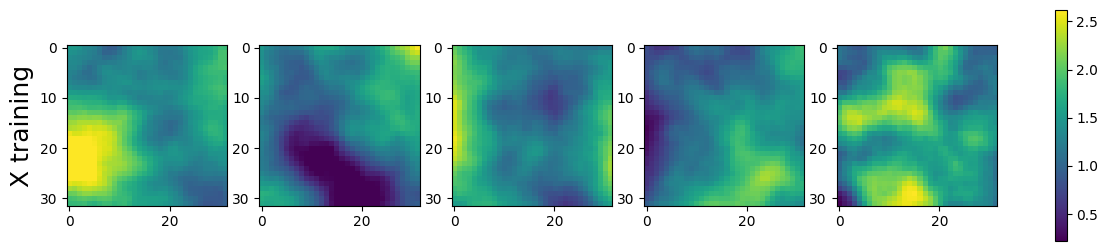

In [4]:
## Prepare training dataset

GP_2C = true_GPPrior(lengthscale=length_scale_x, var=var_x, nu=nu_x, device=device, dims=dims)
x_train = GP_2C.sample_train_data(dims=dims, n_samples=train_samples*3)

x_train = x_train.reshape(train_samples, 3, *dims)
loader_tr = DataLoader(x_train, batch_size=batch_size, shuffle=True)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:, 0, :,:])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,0,:,:].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

In [9]:
for i in range(N):
    model = FNO(modes, vis_channels=3, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)
    fmot.train(loader_tr, optimizer, epochs=epochs, scheduler=scheduler, eval_int=int(0), save_int=int(500), generate=False, save_path=spath,saved_model=saved_model)


tr @ epoch 1/500 | Loss 0.931106 | 7.56 (s)
tr @ epoch 2/500 | Loss 0.405258 | 7.13 (s)
tr @ epoch 3/500 | Loss 0.325156 | 7.15 (s)
tr @ epoch 4/500 | Loss 0.305331 | 7.15 (s)
tr @ epoch 5/500 | Loss 0.290220 | 7.14 (s)
tr @ epoch 6/500 | Loss 0.287310 | 7.15 (s)
tr @ epoch 7/500 | Loss 0.282341 | 7.14 (s)
tr @ epoch 8/500 | Loss 0.279372 | 7.15 (s)
tr @ epoch 9/500 | Loss 0.276745 | 7.13 (s)
tr @ epoch 10/500 | Loss 0.272071 | 7.16 (s)
tr @ epoch 11/500 | Loss 0.269007 | 7.15 (s)
tr @ epoch 12/500 | Loss 0.269283 | 7.16 (s)
tr @ epoch 13/500 | Loss 0.267091 | 7.17 (s)
tr @ epoch 14/500 | Loss 0.265290 | 7.17 (s)
tr @ epoch 15/500 | Loss 0.265484 | 7.15 (s)
tr @ epoch 16/500 | Loss 0.261705 | 7.15 (s)
tr @ epoch 17/500 | Loss 0.264654 | 7.15 (s)
tr @ epoch 18/500 | Loss 0.262970 | 7.16 (s)
tr @ epoch 19/500 | Loss 0.259974 | 7.16 (s)
tr @ epoch 20/500 | Loss 0.260398 | 7.16 (s)
tr @ epoch 21/500 | Loss 0.261565 | 7.16 (s)
tr @ epoch 22/500 | Loss 0.261012 | 7.16 (s)
tr @ epoch 23/500 |

tr @ epoch 182/500 | Loss 0.243692 | 7.25 (s)
tr @ epoch 183/500 | Loss 0.242112 | 7.25 (s)
tr @ epoch 184/500 | Loss 0.241139 | 7.25 (s)
tr @ epoch 185/500 | Loss 0.242277 | 7.25 (s)
tr @ epoch 186/500 | Loss 0.245380 | 7.24 (s)
tr @ epoch 187/500 | Loss 0.240208 | 7.24 (s)
tr @ epoch 188/500 | Loss 0.242381 | 7.24 (s)
tr @ epoch 189/500 | Loss 0.243043 | 7.20 (s)
tr @ epoch 190/500 | Loss 0.242691 | 7.24 (s)
tr @ epoch 191/500 | Loss 0.242534 | 7.24 (s)
tr @ epoch 192/500 | Loss 0.243149 | 7.24 (s)
tr @ epoch 193/500 | Loss 0.243987 | 7.26 (s)
tr @ epoch 194/500 | Loss 0.241608 | 7.24 (s)
tr @ epoch 195/500 | Loss 0.242082 | 7.25 (s)
tr @ epoch 196/500 | Loss 0.241026 | 7.25 (s)
tr @ epoch 197/500 | Loss 0.241104 | 7.24 (s)
tr @ epoch 198/500 | Loss 0.242685 | 7.25 (s)
tr @ epoch 199/500 | Loss 0.241856 | 7.23 (s)
tr @ epoch 200/500 | Loss 0.241844 | 7.27 (s)
tr @ epoch 201/500 | Loss 0.242258 | 7.26 (s)
tr @ epoch 202/500 | Loss 0.242069 | 7.25 (s)
tr @ epoch 203/500 | Loss 0.239162

tr @ epoch 361/500 | Loss 0.239469 | 7.33 (s)
tr @ epoch 362/500 | Loss 0.238188 | 7.44 (s)
tr @ epoch 363/500 | Loss 0.236525 | 7.42 (s)
tr @ epoch 364/500 | Loss 0.238927 | 7.35 (s)
tr @ epoch 365/500 | Loss 0.238753 | 7.38 (s)
tr @ epoch 366/500 | Loss 0.239844 | 7.38 (s)
tr @ epoch 367/500 | Loss 0.239865 | 7.37 (s)
tr @ epoch 368/500 | Loss 0.237852 | 7.38 (s)
tr @ epoch 369/500 | Loss 0.238150 | 7.48 (s)
tr @ epoch 370/500 | Loss 0.236665 | 7.30 (s)
tr @ epoch 371/500 | Loss 0.239008 | 7.50 (s)
tr @ epoch 372/500 | Loss 0.241002 | 7.47 (s)
tr @ epoch 373/500 | Loss 0.238012 | 7.36 (s)
tr @ epoch 374/500 | Loss 0.239747 | 7.27 (s)
tr @ epoch 375/500 | Loss 0.238794 | 7.28 (s)
tr @ epoch 376/500 | Loss 0.237063 | 7.29 (s)
tr @ epoch 377/500 | Loss 0.238854 | 7.26 (s)
tr @ epoch 378/500 | Loss 0.237921 | 7.15 (s)
tr @ epoch 379/500 | Loss 0.235981 | 7.13 (s)
tr @ epoch 380/500 | Loss 0.238502 | 7.14 (s)
tr @ epoch 381/500 | Loss 0.241658 | 7.14 (s)
tr @ epoch 382/500 | Loss 0.236895

## load trained model

In [16]:
## load trained model
model = FNO(modes, vis_channels=1, hidden_channels=width, proj_channels=mlp_width, x_dim=2, t_scaling=1).to(device)
 
for param in model.parameters():
    param.requires_grad = False
    
# paper :model_path = path "paper_saved_models/{}/1D_codomain_649_set1.pt".format(folder)
model_path = os.path.join(spath, 'epoch_500.pt')
checkpoint = torch.load(model_path, map_location='cpu', weights_only=True)
model.load_state_dict(checkpoint)

fmot = OFMModel(model, kernel_length=kernel_length, kernel_variance=kernel_variance, nu=nu, sigma_min=sigma_min, device=device, dims=dims)

## statistical features

In [10]:
x_train = GP_2C.sample_train_data(dims=dims, n_samples=train_samples*3)

x_train = x_train.reshape(train_samples, 3, *dims)

x_hist_true, bin_edges = x_train.histogram(range=[-4,4], density=True)
x_pos = np.linspace(0, 1, n_x)

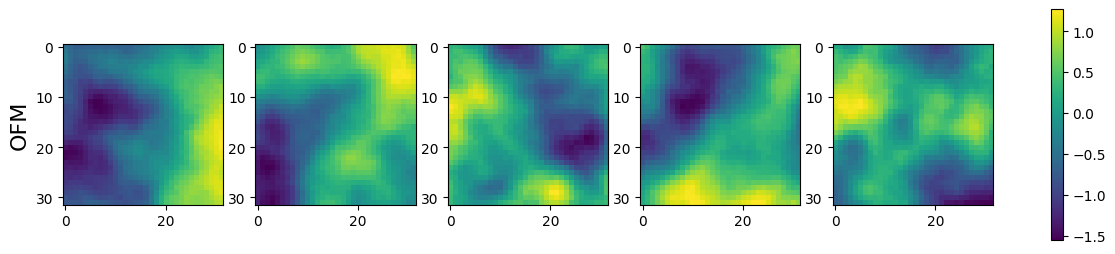

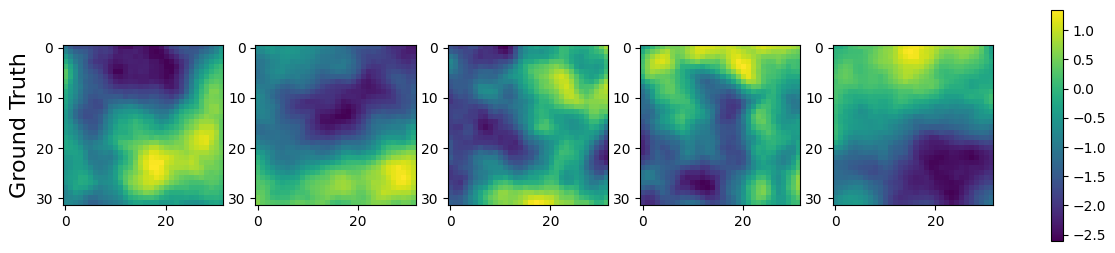

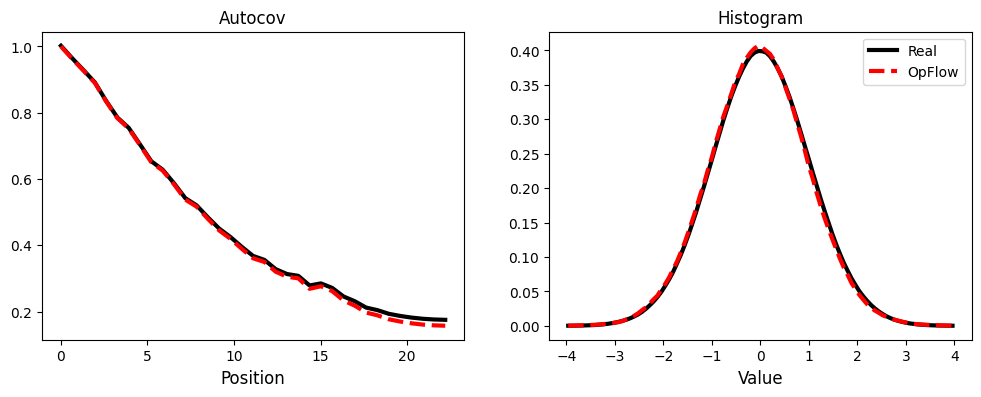

In [14]:
with torch.no_grad():

    X_hat = fmot.sample([n_x, n_x], n_samples=10, n_eval=10, n_channels=3).cpu()
    #X_hat = torch.exp(X_hat*x_std + x_mean).squeeze()
    
    X_ground_truth = x_train[:5,0].squeeze()
    # plot
    
    X_alt = []
    for i in range(3):
        X_temp = fmot.sample([n_x, n_x], n_samples=400, n_eval=10, n_channels=3).cpu().squeeze()
        X_alt.append(X_temp)
        
    X_alt = torch.vstack(X_alt)
    
    bin_center, x_acovf = compute_acovf(X_alt[:,0].squeeze())
    _, x_acovf_true = compute_acovf(x_train[:,0].squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-4,4], density=True)
    x_hist_true, bin_edges = x_train.histogram(range=[-4, 4], density=True)
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,0,:,:].squeeze()

        ax[i].imshow(x)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('OFM', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])
        
    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)#, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
    #plt.show()
    
    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)#, vmin=-2, vmax=2)
        if i == 0:
            ax[i].set_ylabel('Ground Truth', fontsize=16)
 
    bar = ax[4].imshow(x_ground_truth) #, vmin=-2, vmax=2)
    fig.colorbar(bar, ax=ax)
   
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(bin_center, x_acovf_true, c='k', lw=3)
    ax[0].plot(bin_center, x_acovf, c='r',ls='--', lw=3)
    #ax[0].set_ylim(0.2, 0.45)
    ax[0].set_title('Autocov')
    ax[0].set_xlabel('Position', fontsize='large')
    ax[1].plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true, c='k', lw=3, label='Real')
    ax[1].plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='r', ls='--', lw=3, label='OpFlow')
    ax[1].set_title('Histogram')
    ax[1].legend(loc='upper right')
    ax[1].set_xlabel('Value', fontsize='large')
    #plt.savefig("plots/GP2GP/epoch_{}.pdf".format(epoch))